In [2]:
%load_ext autoreload
%autoreload 2

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
The log likelihood of the GBM is 2261.72.


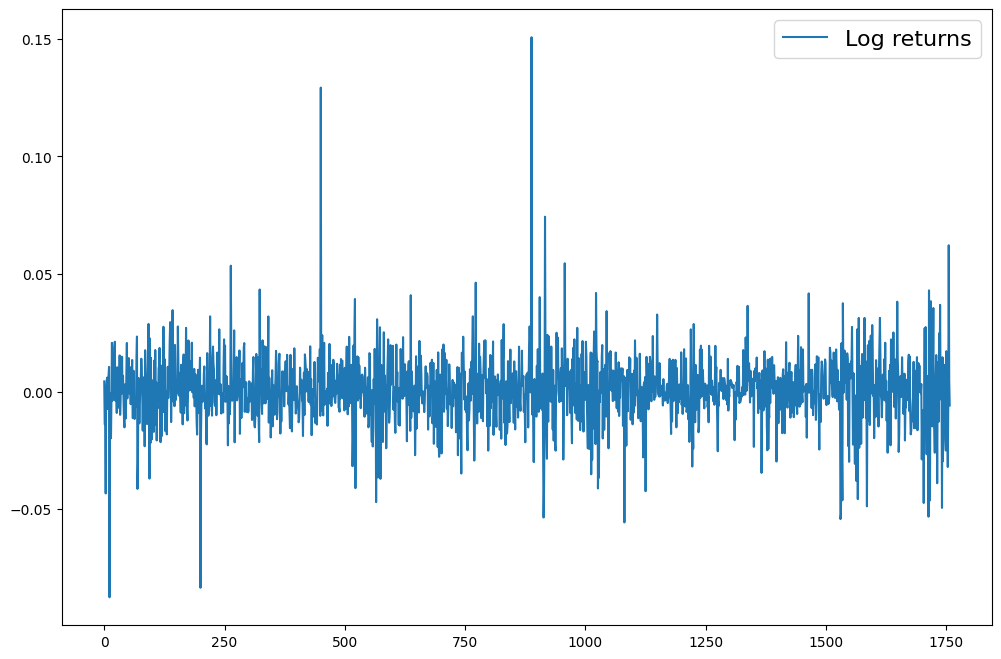

In [3]:
from brownian import log_likelihood, estimate_gbm_parameters
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Download the data.
stock = "GOOGL"
data = yf.download(stock, start="2012-01-01", end="2018-12-31")
data_future = yf.download(stock, start="2018-01-01", end="2022-12-31")

# Extract the adjusted closing prices.
prices = data["Adj Close"].values
prices_future = data_future["Adj Close"].values

# Compute the log returns.
log_returns = np.log(prices[1:]/prices[:-1])
log_returns_future = np.log(prices_future[1:]/prices_future[:-1])

# Set the time step.
dt = 1/252

# Estimate the parameters of the GBM.
mu, sigma = estimate_gbm_parameters(prices, dt)


# Compute the log likelihood of the GBM.
ll = log_likelihood(np.array([mu, sigma]), prices_future, dt)
print(f"The log likelihood of the GBM is {ll:.2f}.")


# Plot the log returns.
plt.figure(figsize=(12, 8))
plt.plot(log_returns, label="Log returns")
plt.legend(fontsize=16)
plt.show()


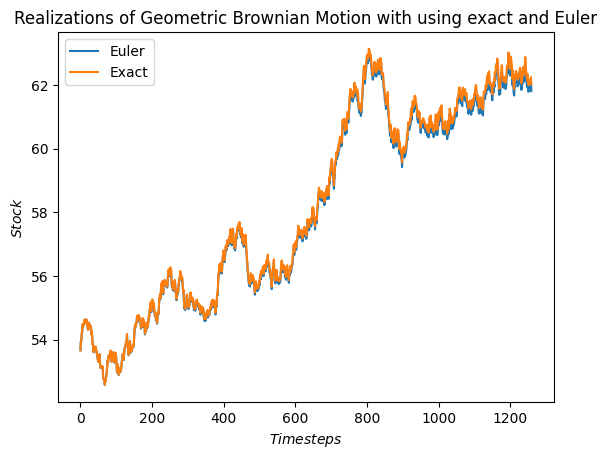

In [4]:
# Compare

T = 1
n = len(prices_future)
dt = T/n
x0 = prices_future[0]

#np.random.seed(42) #This one can be included to use the same simulations every time the code is run.
Stock = np.zeros((n+1,2))
Stock[0,0] = x0
Stock[0,1] = x0

dWt = np.random.normal(0, np.sqrt(dt), size=(1, n)).T

for i in range(1,n+1,1):
    Stock[i,0] = Stock[i-1,0] +(mu-sigma**2/2)*Stock[i-1,0]*dt + sigma*Stock[i-1,0]*dWt[i-1,0]
    Stock[i,1] = Stock[i-1,1]*np.exp((mu-sigma**2/2)*dt + sigma*dWt[i-1,0])

plt.plot(Stock)
plt.xlabel("$Time steps$")
plt.legend(['Euler', 'Exact'])
plt.ylabel("$Stock$")
plt.title(
    "Realizations of Geometric Brownian Motion with using exact and Euler"
)
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_gbm(prices, mu=None, sigma=None, dt=None, num_simulations=1000, num_periods=252):
    # Sample stock data (replace with your actual data)
    stock_prices = prices

    # Calculate logarithmic returns
    returns = np.log(np.array(stock_prices[1:]) / np.array(stock_prices[:-1]))

    # Set the time step.
    if dt is None:
        dt = 1 / len(stock_prices)

    # Estimate the parameters of the GBM.
    if mu is None or sigma is None:
        mu, sigma = estimate_gbm_parameters(prices, dt)

    # Set parameters
    initial_price = stock_prices[0]
    if num_periods is None:
        num_periods = len(stock_prices)

    # Choose interest rate (r)
    interest_rate = 0.05  # Replace with an appropriate value

    # Simulate GBM
    simulated_prices = np.zeros((num_simulations, num_periods))
    simulated_prices[:, 0] = initial_price

    for i in range(num_simulations):
        for j in range(1, num_periods):
            z = np.random.normal(0, 1)
            simulated_prices[i, j] = simulated_prices[i, j-1] * np.exp(
                (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z
            )

    return simulated_prices, dt


mu = 0.0075, sigma = 0.0992


ValueError: x and y must have same first dimension, but have shapes (4,) and (1759, 1000)

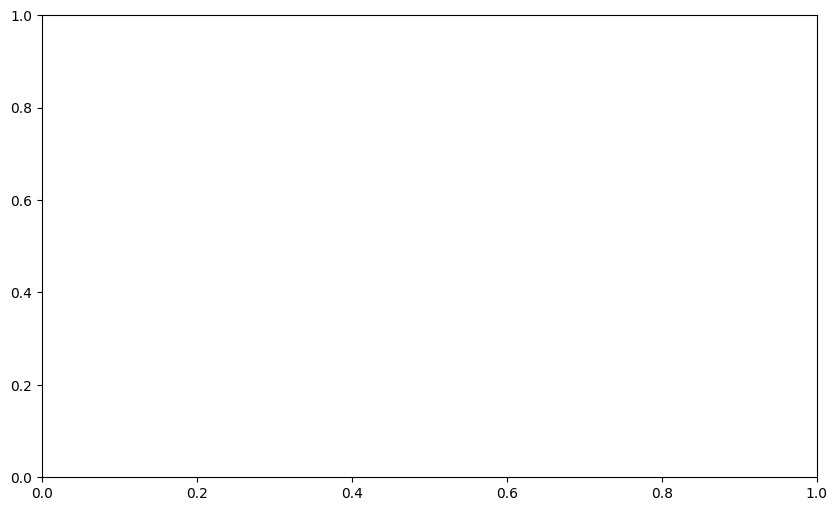

In [14]:
num_periods = 4#len(prices)
dt = 1 / num_periods

mu, sigma = estimate_gbm_parameters(prices, dt)
print(f"mu = {mu:.4f}, sigma = {sigma:.4f}")

simulated_prices, dt = simulate_gbm(prices, mu=mu, sigma=sigma, dt=dt, num_simulations=1000)

# Plot simulated prices
plt.figure(figsize=(10, 6))
#plt.plot(range(len(prices)), prices, 'b-', label='Actual Prices')
plt.plot(range(num_periods), simulated_prices.T, 'r-', alpha=0.05)
#plt.plot(range(num_periods), np.mean(simulated_prices, axis=0), 'green', alpha=1)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Geometric Brownian Motion - Simulated Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

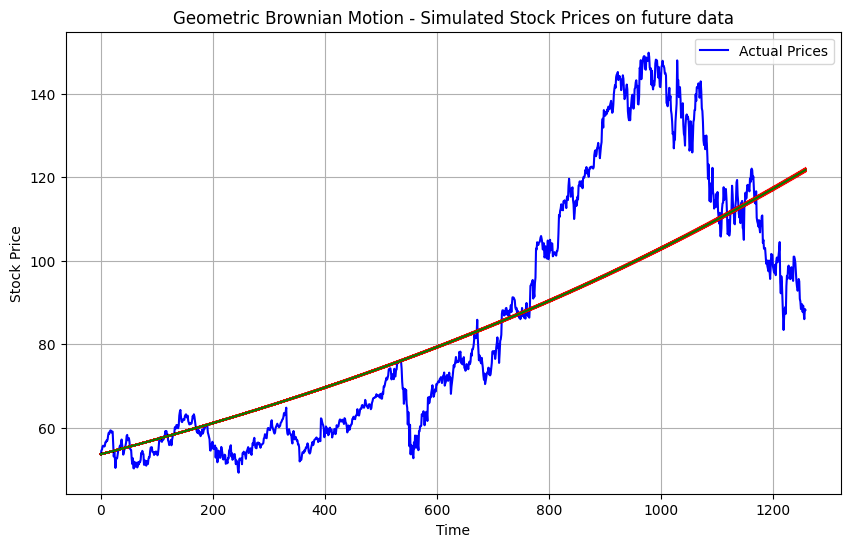

In [7]:
num_periods = len(prices_future)
simulated_prices, dt = simulate_gbm(prices_future, mu=mu, sigma=sigma, dt=dt, num_simulations=1000)

# Plot simulated prices
plt.figure(figsize=(10, 6))
plt.plot(range(num_periods), prices_future, 'b-', label='Actual Prices')
plt.plot(range(num_periods), simulated_prices.T, 'r-', alpha=0.05)
plt.plot(range(num_periods), np.mean(simulated_prices, axis=0), 'green', alpha=1)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Geometric Brownian Motion - Simulated Stock Prices on future data')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import math

def compute_binomial_price(S, K, r, sigma, T, n):
    dt = T / n
    U = math.exp(sigma * math.sqrt(dt)) - 1
    D = -math.exp(-sigma * math.sqrt(dt)) + 1
    R = math.exp(r * dt) - 1

    # Build the binomial tree
    tree = [[0 for j in range(i + 1)] for i in range(n + 1)]
    for i in range(n + 1):
        for j in range(i + 1):
            tree[i][j] = S * (1 + U) ** j * (1 + D) ** (i - j)

    # Compute option prices at each node
    option_prices = [0 for _ in range(n + 1)]
    for j in range(n + 1):
        option_prices[j] = max(tree[n][j] - K, 0)

    # Move backward in time to compute option prices at earlier nodes
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            option_prices[j] = (R * option_prices[j] + (1 - R) * option_prices[j + 1]) / (1 + R)

    return option_prices[0]

# Example usage
S = 100  # Stock price
K = 100  # Strike price
r = 0.05  # Risk-free interest rate
sigma = 0.2  # Volatility
T = 0.25  # Time to expiry in years
n = 100  # Number of time steps

binomial_price = compute_binomial_price(S, K, r, sigma, T, n)
print("Price of the ATM call option using the binomial model:", binomial_price)


Price of the ATM call option using the binomial model: 169.69336662906


In [9]:
import math

def compute_binomial_price(S, K, r, sigma, T, n, option_type='European'):
    dt = T / n
    U = math.exp(sigma * math.sqrt(dt)) - 1
    D = -math.exp(-sigma * math.sqrt(dt)) + 1
    R = math.exp(r * dt) - 1

    # Build the binomial tree
    tree = [[0 for j in range(i + 1)] for i in range(n + 1)]
    for i in range(n + 1):
        for j in range(i + 1):
            tree[i][j] = S * (1 + U) ** j * (1 + D) ** (i - j)

    # Compute option prices at each node
    option_prices = [0 for _ in range(n + 1)]
    for j in range(n + 1):
        if option_type == 'European':
            option_prices[j] = max(K - tree[n][j], 0)  # European put option
        elif option_type == 'American':
            option_prices[j] = max(K - tree[n][j], 0)  # American put option

    # Move backward in time to compute option prices at earlier nodes
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            if option_type == 'European':
                option_prices[j] = (R * option_prices[j] + (1 - R) * option_prices[j + 1]) / (1 + R)
            elif option_type == 'American':
                early_exercise = K - tree[i][j]  # Potential early exercise value
                discounted_value = (R * option_prices[j] + (1 - R) * option_prices[j + 1]) / (1 + R)
                option_prices[j] = max(early_exercise, discounted_value)

    return option_prices[0]

# Example usage
S = 100  # Stock price
K = 100  # Strike price
r = 0.05  # Risk-free interest rate
sigma = 0.2  # Volatility
T = 0.25  # Time to expiry in years
n = 100  # Number of time steps

european_put_price = compute_binomial_price(S, K, r, sigma, T, n, option_type='European')
american_put_price = compute_binomial_price(S, K, r, sigma, T, n, option_type='American')

print("Price of the ATM European put option using the binomial model:", european_put_price)
print("Price of the ATM American put option using the binomial model:", american_put_price)


Price of the ATM European put option using the binomial model: 0.0
Price of the ATM American put option using the binomial model: 0.0


[*********************100%***********************]  1 of 1 completed


<AxesSubplot: xlabel='Date'>

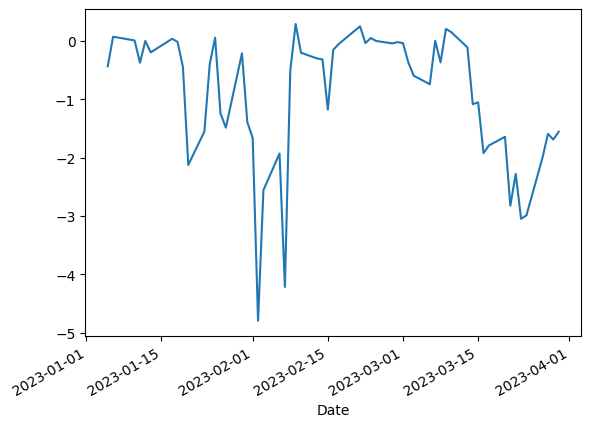

In [10]:
import numpy as np
import pandas as pd
import scipy.stats as si





# Load the stock data
stock_data = yf.download(stock, start="2023-01-01", end="2023-03-31")


# Define the option parameters
S = stock_data['Adj Close'][0]  # current stock price
K = S  # strike price
r = 0.05  # risk-free rate
sigma = 0.2  # volatility
T = 0.25  # time to maturity in years

# Calculate the option price and Delta using Black-Scholes formula
d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
delta = si.norm.cdf(d1)

# Calculate the daily returns
returns = stock_data['Adj Close'].pct_change().dropna()

# Create a DataFrame to store the hedging results
hedge_results = pd.DataFrame(index=returns.index, columns=['option_delta', 'hedge_position', 'hedge_pnl'])

# Initialize the hedge
option_delta = delta
hedge_position = option_delta * S
hedge_results.loc[returns.index[0], 'option_delta'] = option_delta
hedge_results.loc[returns.index[0], 'hedge_position'] = hedge_position

# Perform delta hedging over the lifetime of the option
for i in range(1, len(returns)):
    # Calculate the new option Delta using the new stock price
    S_new = stock_data.loc[returns.index[i], 'Adj Close']
    d1_new = (np.log(S_new/K) + (r + 0.5*sigma**2)*(T - i/252)) / (sigma*np.sqrt(T - i/252))
    option_delta_new = si.norm.cdf(d1_new)
    hedge_results.loc[returns.index[i], 'option_delta'] = option_delta_new
    
    # Calculate the change in the hedge position and P&L
    hedge_position_change = option_delta_new * S_new - option_delta * S
    hedge_pnl = hedge_position_change - (hedge_position_change / S) * S_new
    
    # Update the hedge position and option Delta
    hedge_position += hedge_position_change
    option_delta = option_delta_new
    
    # Store the results
    hedge_results.loc[returns.index[i], 'hedge_position'] = hedge_position
    hedge_results.loc[returns.index[i], 'hedge_pnl'] = hedge_pnl

# Plot the results
hedge_results['hedge_pnl'].plot()


[*********************100%***********************]  1 of 1 completed


<AxesSubplot: xlabel='Date'>

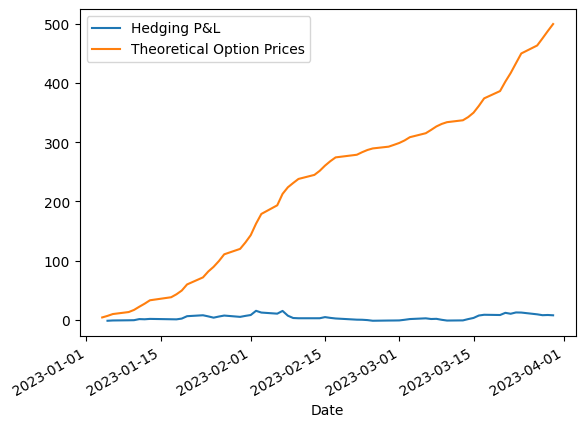

In [11]:
import numpy as np
import pandas as pd
import scipy.stats as si

# Load the stock data
stock_data = yf.download(stock, start="2023-01-01", end="2023-03-31")


# Define the option parameters
S = stock_data['Adj Close'][0]  # current stock price
K = S  # strike price
r = 0.05  # risk-free rate
sigma = 0.2  # volatility
T = 0.25  # time to maturity in years

# Calculate the option price and Delta using Black-Scholes formula
d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
option_price = S * si.norm.cdf(d1) - K * np.exp(-r*T) * si.norm.cdf(d1 - sigma*np.sqrt(T))
delta = si.norm.cdf(d1)

# Calculate the daily returns
returns = stock_data['Adj Close'].pct_change().dropna()

# Create a DataFrame to store the hedging results
hedge_results = pd.DataFrame(index=returns.index, columns=['option_price', 'hedge_pnl'])

# Initialize the hedge
hedge_results.loc[returns.index[0], 'option_price'] = option_price

# Perform delta hedging over the lifetime of the option
for i in range(1, len(returns)):
    # Calculate the new option price using the new stock price
    S_new = stock_data.loc[returns.index[i], 'Adj Close']
    d1_new = (np.log(S_new/K) + (r + 0.5*sigma**2)*(T - i/252)) / (sigma*np.sqrt(T - i/252))
    option_price_new = S_new * si.norm.cdf(d1_new) - K * np.exp(-r*(T - i/252)) * si.norm.cdf(d1_new - sigma*np.sqrt(T - i/252))
    hedge_results.loc[returns.index[i], 'option_price'] = option_price_new
    
    # Calculate the change in the hedge P&L
    hedge_pnl = option_price_new - option_price
    
    # Update the option price
    option_price = option_price_new
    
    # Store the results
    hedge_results.loc[returns.index[i], 'hedge_pnl'] = hedge_pnl

# Compare the hedging costs with the theoretical option prices
hedge_pnl = hedge_results['hedge_pnl'].cumsum()
theoretical_option_prices = hedge_results['option_price'].cumsum()

# Plot the comparison
comparison = pd.DataFrame({'Hedging P&L': hedge_pnl, 'Theoretical Option Prices': theoretical_option_prices})
comparison.plot()


<AxesSubplot: xlabel='Date'>

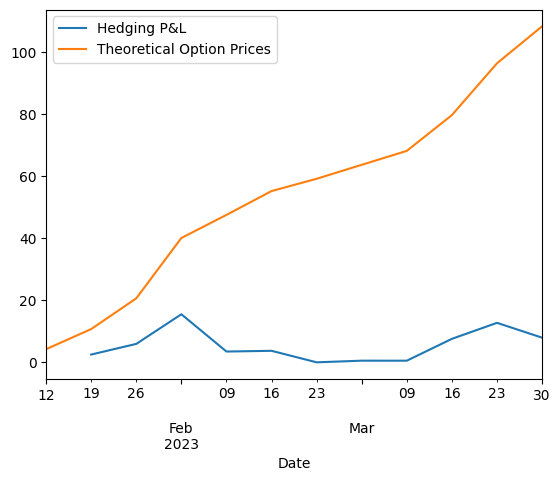

In [12]:
import numpy as np
import pandas as pd
import scipy.stats as si

# Define the option parameters
S = stock_data['Adj Close'][0]  # current stock price
K = S  # strike price
r = 0.05  # risk-free rate
sigma = 0.2  # volatility
T = 0.25  # time to maturity in years

# Calculate the option price and Delta using Black-Scholes formula
d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
option_price = S * si.norm.cdf(d1) - K * np.exp(-r*T) * si.norm.cdf(d1 - sigma*np.sqrt(T))
delta = si.norm.cdf(d1)


# Calculate the weekly returns
weekly_returns = stock_data['Adj Close'].resample('W-THU').ffill().pct_change().dropna()

# Create a DataFrame to store the hedging results
hedge_results = pd.DataFrame(index=weekly_returns.index, columns=['option_price', 'hedge_pnl'])

# Initialize the hedge
hedge_results.loc[weekly_returns.index[0], 'option_price'] = option_price

# Perform delta hedging over the lifetime of the option with weekly rebalancing
for i in range(1, len(weekly_returns)):
    # Calculate the new option price using the new stock price
    S_new = stock_data.loc[weekly_returns.index[i], 'Adj Close']
    d1_new = (np.log(S_new/K) + (r + 0.5*sigma**2)*(T - (i/52))) / (sigma*np.sqrt(T - (i/52)))
    option_price_new = S_new * si.norm.cdf(d1_new) - K * np.exp(-r*(T - (i/52))) * si.norm.cdf(d1_new - sigma*np.sqrt(T - (i/52)))
    hedge_results.loc[weekly_returns.index[i], 'option_price'] = option_price_new
    
    # Calculate the change in the hedge P&L
    hedge_pnl = option_price_new - option_price
    
    # Update the option price
    option_price = option_price_new
    
    # Store the results
    hedge_results.loc[weekly_returns.index[i], 'hedge_pnl'] = hedge_pnl

# Compare the hedging costs with the theoretical option prices
hedge_pnl = hedge_results['hedge_pnl'].cumsum()
theoretical_option_prices = hedge_results['option_price'].cumsum()

# Plot the comparison
comparison = pd.DataFrame({'Hedging P&L': hedge_pnl, 'Theoretical Option Prices': theoretical_option_prices})
comparison.plot()
